# Апробация модели мультиэкспоненциального частотного скана на данных из набора "1564ЛЕ1 при разных U1 Ur август 2022"

## 0. Импорт модулей

In [1]:
from os import listdir
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from fsmodels import SklMultiExpFrequencyScan, FrequencyScan

%matplotlib inline

## 1. Чтение данных

In [2]:
DATASET_PATH = '../dataset/'
PLOTS_PATH = '../plots/'
MODELS_PATH = '../models/'

In [3]:
file_names = listdir(DATASET_PATH)

In [4]:
u1 = -4
ur = -5

data_frames = [[file_name, pd.read_csv(DATASET_PATH + file_name, parse_dates=[0])] for file_name in file_names]

condition = lambda frame: frame.loc[0, 'u1']==u1 and frame.loc[0, 'ur']==ur
data_frames = [[name, frame] for [name, frame] in data_frames if condition(frame)]

In [5]:
len(data_frames)

3

In [6]:
print(data_frames[0][0])
data_frames[0][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_10пФ_+30С_-4В-5В_50мВ_10мкс_шаг_0,1.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-03 14:34:48,2500.0000,1.456,303.264,0.007280,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-03 14:34:52,1985.8207,1.526,303.276,0.007630,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-03 14:34:56,1577.3937,1.649,303.279,0.008245,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-03 14:35:00,1252.9686,1.755,303.281,0.008775,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-03 14:35:03,995.2686,1.907,303.281,0.009535,10,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [7]:
data_frames[0][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               34 non-null     datetime64[ns]
 1   frequency_hz       34 non-null     float64       
 2   dlts_v             34 non-null     float64       
 3   temperature_k      34 non-null     float64       
 4   dlts_pf            34 non-null     float64       
 5   bs                 34 non-null     int64         
 6   ls                 34 non-null     int64         
 7   f_pulse            34 non-null     float64       
 8   u1                 34 non-null     float64       
 9   ur                 34 non-null     float64       
 10  time_between_meas  34 non-null     float64       
 11  integral_time      34 non-null     float64       
 12  specimen_name      34 non-null     object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usage:

In [8]:
print(data_frames[1][0])
data_frames[1][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_+10С_-4В-5В_50мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-04 15:21:09,2500.0000,3.122,283.194,0.001561,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-04 15:21:13,2443.0925,3.187,283.187,0.001593,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-04 15:21:17,2387.4812,3.201,283.191,0.001600,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-04 15:21:21,2333.1355,3.259,283.206,0.001629,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-04 15:21:25,2280.0269,3.271,283.199,0.001636,1,50,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [9]:
data_frames[1][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

In [10]:
print(data_frames[2][0])
data_frames[2][1].head()

1564ЛЕ1№1_п1_2500Гц-1Гц_1пФ_-10С_-4В-5В_10мВ_10мкс_шаг_0,01.csv


,time,frequency_hz,dlts_v,temperature_k,dlts_pf,bs,ls,f_pulse,u1,ur,time_between_meas,integral_time,specimen_name
0,2022-08-02 17:55:01,2500.0000,5.276,262.940,0.000528,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
1,2022-08-02 17:55:05,2443.0925,5.449,262.941,0.000545,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
2,2022-08-02 17:55:09,2387.4812,5.855,262.941,0.000585,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
3,2022-08-02 17:55:13,2333.1355,6.665,262.940,0.000666,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1
4,2022-08-02 17:55:17,2280.0269,6.626,262.936,0.000663,1,10,10.0,-4.0,-5.0,3.5,3.0,1564ЛЕ1№1 п1


In [11]:
data_frames[2][1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   time               340 non-null    datetime64[ns]
 1   frequency_hz       340 non-null    float64       
 2   dlts_v             340 non-null    float64       
 3   temperature_k      340 non-null    float64       
 4   dlts_pf            340 non-null    float64       
 5   bs                 340 non-null    int64         
 6   ls                 340 non-null    int64         
 7   f_pulse            340 non-null    float64       
 8   u1                 340 non-null    float64       
 9   ur                 340 non-null    float64       
 10  time_between_meas  340 non-null    float64       
 11  integral_time      340 non-null    float64       
 12  specimen_name      340 non-null    object        
dtypes: datetime64[ns](1), float64(9), int64(2), object(1)
memory usag

## 2. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_10пФ\_+30С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,1.csv
### 2.1. Подготовка экспериментальных данных

In [12]:
def get_X_y(dataset):
    filling_pulse = dataset.f_pulse[0] * 10 ** -6
    X_train = np.log10(dataset.frequency_hz.to_numpy())
    y_train = dataset.dlts_pf.to_numpy()
    
    return filling_pulse, X_train, y_train

In [13]:
filling_pulse, X_train, y_train = get_X_y(data_frames[0][1])

In [14]:
normalize = lambda X, y: (X.max() / y.max(), y * X.max() / y.max())
denormalize = lambda X, y_normalized: y_normalized * y_normalized.max() / X.max()

In [15]:
k, y_train = normalize(X_train, y_train)
k

180.3577499295137

In [16]:
def plot_X_y(X, y):
    plt.plot(X, y, 'og', alpha=0.3)
    plt.grid()
    plt.show()

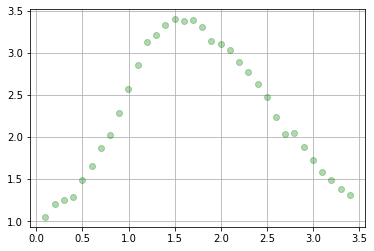

In [17]:
plot_X_y(X_train, y_train)

### 2.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [18]:
monoexp_fs = FrequencyScan(amplitude = y_train.max(),
                           time_constant_power = - X_train[np.argmax(y_train)],
                           filling_pulse = filling_pulse,
                           learning_rate = 0.05,
                           stop_val = 10**-5,
                           verbose = False
                          )

fit_results = monoexp_fs.fit(f_powers = X_train, dlts_vals = y_train)
fit_results

,amplitude,time_constant_power,p_coef,loss
0,3.39794,-1.497941,1.0,1.784289
1,3.413625,-1.630512,0.914709,1.324248
2,3.433284,-1.726078,0.82396,0.993366
3,3.454267,-1.790849,0.728625,0.730245
4,3.474723,-1.832751,0.63023,0.499691
...,...,...,...,...
72,3.391239,-1.918811,0.284343,0.014216
73,3.390493,-1.918831,0.284217,0.014205
74,3.389769,-1.918851,0.284095,0.014194
75,3.389064,-1.918871,0.283975,0.014184


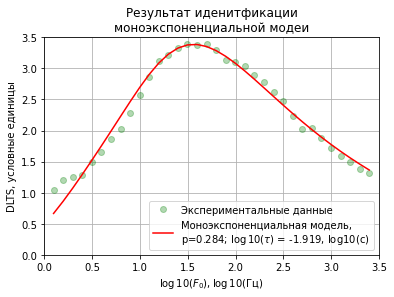

In [19]:
y_pred = monoexp_fs(X_train)

plt.plot(X_train, y_train, 'og', alpha=0.3, label='Экспериментальные данные')
plt.plot(X_train, y_pred, '-r', 
         label=f'Моноэкспоненциальная модель,\n' + 
               f'p={fit_results.p_coef.iloc[-1]:.3f}; ' + 
               f'$\\log10(\\tau)$ = {fit_results.time_constant_power.iloc[-1]:.3f}, log10(c)'
        )
plt.grid()
plt.legend()
plt.title('Результат иденитфикации\nмоноэкспоненциальной модеи')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.ylabel('DLTS, условные единицы')
plt.ylim(0, 3.5)
plt.xlim(0, 3.5)
plt.show()

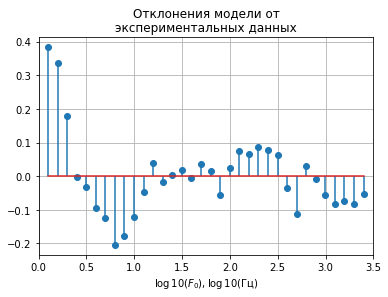

In [20]:
plt.stem(X_train, (y_train - y_pred))
plt.grid()
plt.title('Oтклонения модели от\nэкспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

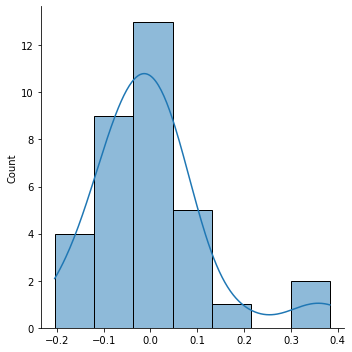

In [21]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [22]:
mean_squared_error(y_train, y_pred, squared=False)

0.11901772955759418

### 2.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [23]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       stop_val = 10**-5,
                                       learning_rate=0.05,
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [24]:
fit_results = multiexp_fs.fit_results_
fit_results

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0
0,1,0.00001,4.4518,-2.813607,1.000000
1,1,0.00001,4.323239,-2.760892,1.059717
2,1,0.00001,4.188221,-2.706380,1.120578
3,1,0.00001,4.047529,-2.650447,1.182572
4,1,0.00001,3.902284,-2.593550,1.245647
...,...,...,...,...,...
180,1,0.00001,0.961438,-1.931479,4.296771
181,1,0.00001,0.961427,-1.931480,4.297525
182,1,0.00001,0.961417,-1.931481,4.298259
183,1,0.00001,0.961406,-1.931481,4.298974


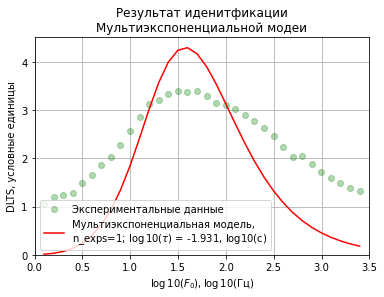

In [25]:
y_pred = multiexp_fs.predict(X_train)

plt.plot(X_train, y_train, 'og', alpha=0.3, label='Экспериментальные данные')
plt.plot(X_train, y_pred, '-r', 
         label=f'Мультиэкспоненциальная модель,\n' + 
               f'n_exps={fit_results.n_exps.iloc[-1]}; ' + 
               f'$\\log10(\\tau)$ = {fit_results.time_constant_power_0.iloc[-1]:.3f}, log10(c)'
        )
plt.grid()
plt.legend()
plt.title('Результат иденитфикации\nМультиэкспоненциальной модеи')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.ylabel('DLTS, условные единицы')
plt.ylim(0, max(plt.ylim()))
plt.xlim(0, 3.5)
plt.show()

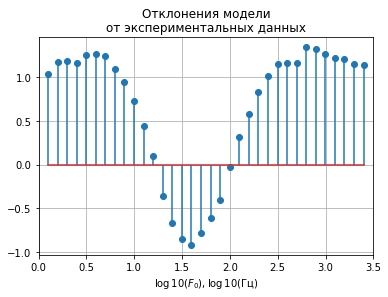

In [26]:
plt.stem(X_train, y_train - y_pred)
plt.grid()
plt.title('Отклонения модели\nот экспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

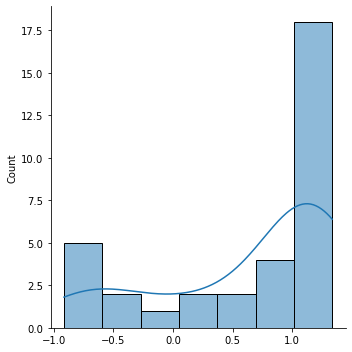

In [27]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

In [28]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [29]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [1.42480004 2.55617671 1.4612024 ]
Mean: 1.8140597185285332
Standard deviation: 0.5249663537323712


In [30]:
mean_squared_error(y_train, y_pred, squared=False)

0.9805038602439051

### 2.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [31]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate = 0.05,
                                       stop_val = 10**-5
                                      )

In [32]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [33]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [34]:
grid_search.best_params_

{'n_exps': 6}

In [35]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.8886731029539467 {'n_exps': 1}
1.2434669225184862 {'n_exps': 2}
0.7596784761998403 {'n_exps': 3}
0.5488839652213008 {'n_exps': 4}
0.5821253423732407 {'n_exps': 5}
0.42346414590664627 {'n_exps': 6}
0.7353228020948731 {'n_exps': 7}
0.9271363143271276 {'n_exps': 8}
1.4641500872202404 {'n_exps': 9}
1.1091186176071655 {'n_exps': 10}


In [36]:
y_pred = grid_search.best_estimator_.predict(X_train)

In [37]:
def plot_ident_res(frequency_powers,
                   experimental_dlts, 
                   fit_results
                  ):
    
    indices = frequency_powers.argsort()
    frequency_powers = frequency_powers[indices]
    experimental_dlts = experimental_dlts[indices]
    
    n_exps=fit_results.loc[0, 'n_exps']
    
    init_params = fit_results.iloc[0, :]
    init_params = [[init_params[f'time_constant_power_{i}'], init_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs = SklMultiExpFrequencyScan(n_exps=n_exps, filling_pulse = fit_results.filling_pulse[0])
    fs.exps_params_ = init_params
    
    initial_model = fs.predict(frequency_powers)
    
    
    final_params = fit_results.iloc[-1, :]
    final_params = [[final_params[f'time_constant_power_{i}'], final_params[f'amplitude_{i}']] for i in range(n_exps)]
    
    fs.exps_params_=final_params
    final_model = fs.predict(frequency_powers)
    

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))

    ax.plot(frequency_powers, experimental_dlts, 'og', alpha=0.3, label='Экспериментальные данные')

    ax.plot(frequency_powers, initial_model, '-b', label='Начальная модель')

    ax.plot(frequency_powers, final_model, '-r', label='Модель после идентификации')

    for i, scan in enumerate(fs._fs_list):
        plt.plot(frequency_powers, scan(frequency_powers), '-.', label=f'exp{i}')

    ax.legend()
    ax.grid()
    ax.set_xlim([0, 3.5])
    ylim = ax.get_ylim()
    ylim = [np.floor(ylim[0]), np.ceil(ylim[1])]
    ax.set_ylim(ylim)
    
    ax.set_title('Результаты идентификации')
    ax.set_xlabel(r'$\log_{10}(F_0), \log_{10}(Гц)$')
    ax.set_ylabel('Сигнал DLTS, условные единицы')
    
    return fig, ax

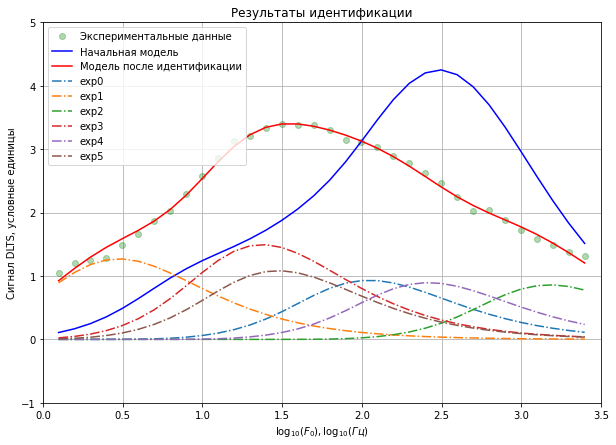

In [38]:
fig, ax = plot_ident_res(X_train,
                         y_train, 
                         grid_search.best_estimator_.fit_results_
                        )

plt.show()

In [39]:
grid_search.best_estimator_.fit_results_

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0,time_constant_power_1,amplitude_1,time_constant_power_2,amplitude_2,time_constant_power_3,amplitude_3,time_constant_power_4,amplitude_4,time_constant_power_5,amplitude_5
0,6,0.00001,1.51489,-2.803726,1.000000,-1.399452,1.000000,-3.181714,1.000000,-2.115745,1.000000,-2.939187,1.000000,-2.710941,1.000000
1,6,0.00001,1.215525,-2.769554,0.964742,-1.388479,1.039436,-3.199755,0.961996,-2.044247,1.008982,-2.924569,0.961427,-2.664407,0.968497
2,6,0.00001,0.981686,-2.736895,0.935692,-1.378192,1.076015,-3.217086,0.929941,-1.983408,1.022430,-2.910904,0.928634,-2.620094,0.943648
3,6,0.00001,0.797932,-2.705959,0.911908,-1.368589,1.109848,-3.233410,0.902933,-1.931748,1.038528,-2.898195,0.900757,-2.578334,0.924400
4,6,0.00001,0.65272,-2.676880,0.892570,-1.359634,1.141067,-3.248569,0.880207,-1.887890,1.055996,-2.886438,0.877063,-2.539314,0.909818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,6,0.00001,0.003749,-2.401877,0.931688,-0.832283,1.271320,-3.551340,0.860198,-1.731170,1.493870,-2.775187,0.894484,-1.831334,1.082222
480,6,0.00001,0.003739,-2.402025,0.931793,-0.831989,1.270916,-3.551521,0.860139,-1.731123,1.494084,-2.775133,0.894644,-1.831067,1.082421
481,6,0.00001,0.003729,-2.402172,0.931899,-0.831696,1.270512,-3.551701,0.860080,-1.731077,1.494298,-2.775079,0.894803,-1.830801,1.082620
482,6,0.00001,0.003719,-2.402318,0.932004,-0.831403,1.270110,-3.551881,0.860021,-1.731030,1.494511,-2.775026,0.894962,-1.830537,1.082819


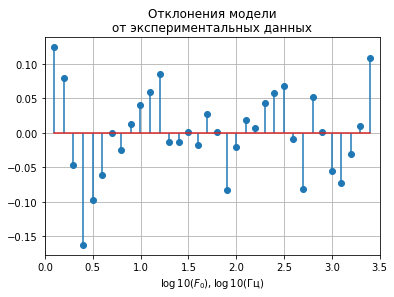

In [40]:
plt.stem(X_train, (y_train - y_pred))
plt.grid()
plt.title('Отклонения модели\nот экспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

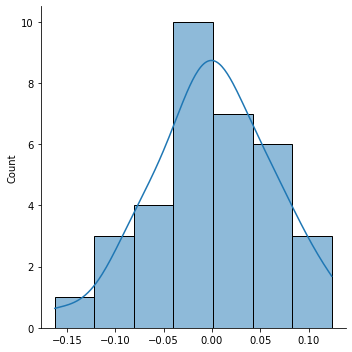

In [41]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

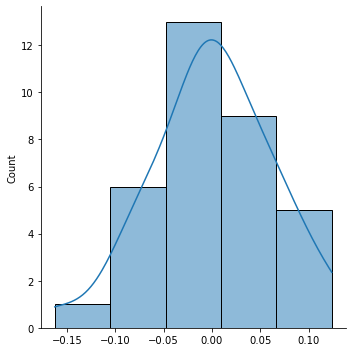

In [45]:
sns.displot(x=y_train - y_pred, bins=5, kde=True)
plt.show()

In [43]:
exps_params_303 = grid_search.best_estimator_.exps_params_
exps_params_303[:, 1] = exps_params_303[:, 1] / k

## 3. 1564ЛЕ1№1\_п1\_2500Гц-1Гц\_1пФ\_+10С\_-4В-5В\_50мВ\_10мкс\_шаг\_0,01.csv
### 3.1. Подготовка экспериментальных данных

In [54]:
filling_pulse, X_train, y_train = get_X_y(data_frames[1][1])

In [55]:
k, y_train = normalize(X_train, y_train)
k

835.2851545408156

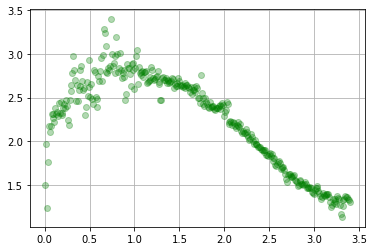

In [56]:
plot_X_y(X_train, y_train)

### 3.2. Идентификация моноэкспоненциальной модели с показателем $p$

In [57]:
monoexp_fs = FrequencyScan(amplitude = y_train.max(),
                           time_constant_power = - X_train[np.argmax(y_train)],
                           filling_pulse = filling_pulse,
                           
                           stop_val = 10**-5,
                           learning_rate=0.05,
                           verbose = False
                          )

fit_results = monoexp_fs.fit(f_powers = X_train, dlts_vals = y_train)
fit_results

,amplitude,time_constant_power,p_coef,loss
0,3.39794,-0.73794,1.0,2.229982
1,3.402435,-0.856468,0.92668,1.847315
2,3.408598,-0.964849,0.848366,1.501605
3,3.416299,-1.055541,0.763066,1.19952
4,3.424727,-1.127838,0.66938,0.921451
...,...,...,...,...
106,2.924509,-1.271338,0.180586,0.018102
107,2.923763,-1.271208,0.180459,0.01809
108,2.923042,-1.27108,0.180337,0.018079
109,2.922343,-1.270956,0.180218,0.018069


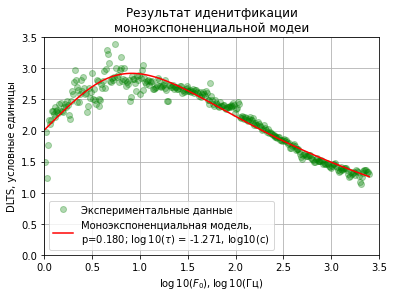

In [58]:
y_pred = monoexp_fs(X_train)

plt.plot(X_train, y_train, 'og', alpha=0.3, label='Экспериментальные данные')
plt.plot(X_train, y_pred, '-r', 
         label=f'Моноэкспоненциальная модель,\n' + 
               f'p={fit_results.p_coef.iloc[-1]:.3f}; ' + 
               f'$\\log10(\\tau)$ = {fit_results.time_constant_power.iloc[-1]:.3f}, log10(c)'
        )
plt.grid()
plt.legend()
plt.title('Результат иденитфикации\nмоноэкспоненциальной модеи')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.ylabel('DLTS, условные единицы')
plt.ylim(0, 3.5)
plt.xlim(0, 3.5)
plt.show()

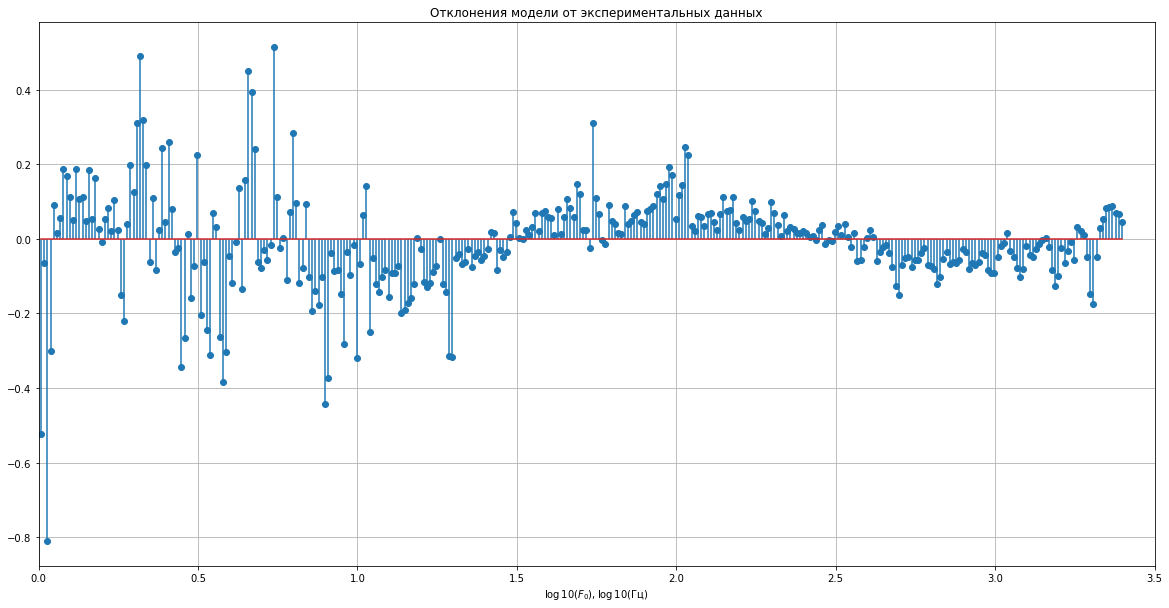

In [59]:
plt.figure(figsize=(20,10))
plt.stem(X_train, (y_train - y_pred))
plt.grid()
plt.title('Oтклонения модели от экспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

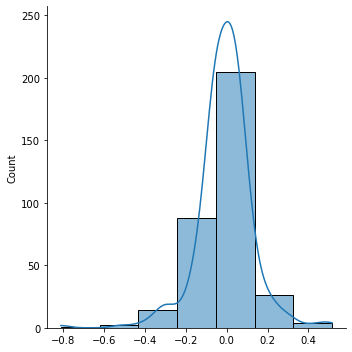

In [60]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

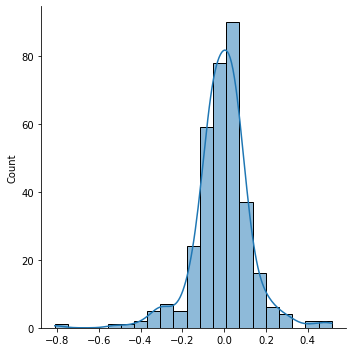

In [61]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [62]:
mean_squared_error(y_train, y_pred, squared=False)

0.13435181379605626

### 3.3. Идентификация мультиэкспоненциальной модели с n_exps=1

In [66]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate=0.05,
                                       stop_val = 10**-5
                                      )

multiexp_fs.fit(X=X_train, y=y_train)

SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                         learning_rate=0.05, stop_val=1e-05)

In [67]:
fit_results = multiexp_fs.fit_results_
fit_results

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0
0,1,0.00001,4.224883,-2.804008,1.000000
1,1,0.00001,4.163682,-2.766326,1.040135
2,1,0.00001,4.100104,-2.727446,1.080603
3,1,0.00001,4.034135,-2.687418,1.121427
4,1,0.00001,3.965788,-2.646299,1.162627
...,...,...,...,...,...
179,1,0.00001,1.345595,-1.340015,3.831216
180,1,0.00001,1.345583,-1.340014,3.831981
181,1,0.00001,1.345572,-1.340013,3.832727
182,1,0.00001,1.345562,-1.340011,3.833453


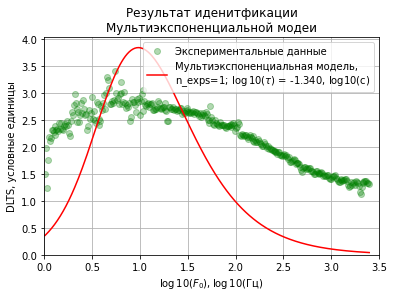

In [68]:
y_pred = multiexp_fs.predict(X_train)

plt.plot(X_train, y_train, 'og', alpha=0.3, label='Экспериментальные данные')
plt.plot(X_train, y_pred, '-r', 
         label=f'Мультиэкспоненциальная модель,\n' + 
               f'n_exps={fit_results.n_exps.iloc[-1]}; ' + 
               f'$\\log10(\\tau)$ = {fit_results.time_constant_power_0.iloc[-1]:.3f}, log10(c)'
        )
plt.grid()
plt.legend()
plt.title('Результат иденитфикации\nМультиэкспоненциальной модеи')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.ylabel('DLTS, условные единицы')
plt.ylim(0, max(plt.ylim()))
plt.xlim(0, 3.5)
plt.show()

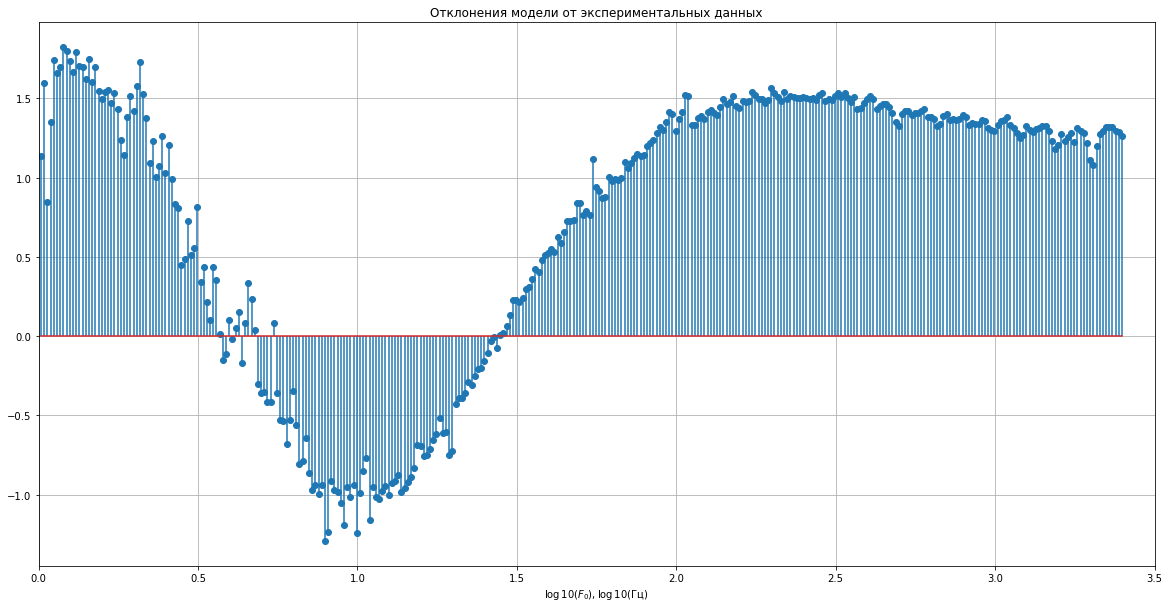

In [69]:
plt.figure(figsize=(20,10))
plt.stem(X_train, (y_train - y_pred))
plt.grid()
plt.title('Oтклонения модели от экспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

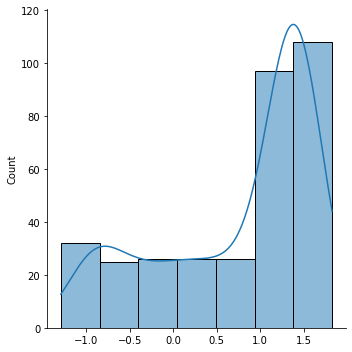

In [70]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

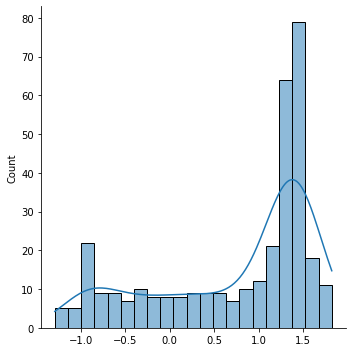

In [71]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [72]:
def display_scores(scores):
    print(f'Scores: {scores}')
    print(f'Mean: {scores.mean()}')
    print(f'Standard deviation: {scores.std()}')

In [73]:
scores = cross_val_score(multiexp_fs, X_train, y_train, scoring='neg_mean_squared_error', cv=3, n_jobs=-1)

display_scores(np.sqrt(-scores))

Scores: [1.42340202 1.6261528  2.36575842]
Mean: 1.8051044113044579
Standard deviation: 0.4049910729649097


In [74]:
mean_squared_error(y_train, y_pred, squared=False)

1.159975384189429

### 3.4. Идентификация мультиэкспоненциальной модели с n_exps>1

In [75]:
multiexp_fs = SklMultiExpFrequencyScan(n_exps = 1,
                                       filling_pulse = filling_pulse,
                                       learning_rate=0.05,
                                       stop_val = 10**-5
                                      )

In [76]:
param_grid = {'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
grid_search = GridSearchCV(multiexp_fs, param_grid, cv=3, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=-1)

In [77]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=SklMultiExpFrequencyScan(filling_pulse=9.999999999999999e-06,
                                                learning_rate=0.05,
                                                stop_val=1e-05),
             n_jobs=-1, param_grid={'n_exps': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [78]:
grid_search.best_params_

{'n_exps': 8}

In [79]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

1.849927256823381 {'n_exps': 1}
1.5133426790259843 {'n_exps': 2}
1.1475597424168988 {'n_exps': 3}
0.9925519549835128 {'n_exps': 4}
0.9697051990226813 {'n_exps': 5}
1.08305628394432 {'n_exps': 6}
0.8183626084192557 {'n_exps': 7}
0.7594598631920242 {'n_exps': 8}
1.253842366399395 {'n_exps': 9}
1.3300356357308578 {'n_exps': 10}


In [80]:
y_pred = grid_search.best_estimator_.predict(X_train)

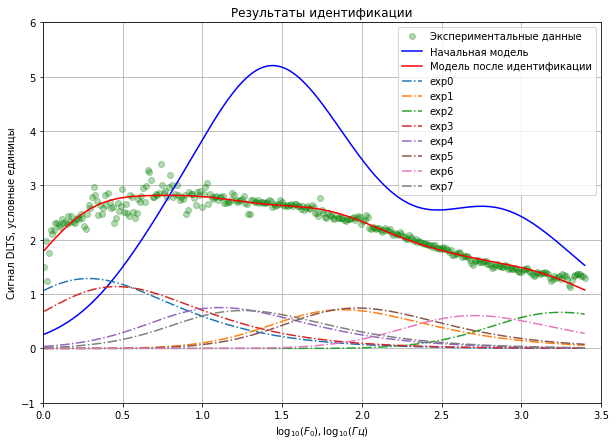

In [81]:
fig, ax = plot_ident_res(X_train,
                         y_train, 
                         grid_search.best_estimator_.fit_results_
                        )

plt.show()

In [82]:
grid_search.best_estimator_.fit_results_

,n_exps,filling_pulse,loss,time_constant_power_0,amplitude_0,time_constant_power_1,amplitude_1,time_constant_power_2,amplitude_2,time_constant_power_3,amplitude_3,time_constant_power_4,amplitude_4,time_constant_power_5,amplitude_5,time_constant_power_6,amplitude_6,time_constant_power_7,amplitude_7
0,8,0.00001,1.994929,-1.167126,1.000000,-1.942802,1.000000,-3.320475,1.000000,-1.434980,1.000000,-1.818796,1.000000,-1.966885,1.000000,-3.282397,1.000000,-1.855927,1.000000
1,8,0.00001,1.434224,-1.082188,0.981426,-1.945764,0.940592,-3.341271,0.976633,-1.361674,0.959528,-1.802095,0.941421,-1.973347,0.940705,-3.302493,0.975855,-1.845332,0.940915
2,8,0.00001,1.061406,-1.013418,0.973624,-1.949463,0.892450,-3.356364,0.956793,-1.296942,0.931795,-1.787490,0.894081,-1.980203,0.892719,-3.316674,0.955434,-1.836481,0.893036
3,8,0.00001,0.808934,-0.958032,0.972982,-1.953181,0.853166,-3.367458,0.939564,-1.240163,0.913798,-1.774231,0.855622,-1.986762,0.853612,-3.326706,0.937767,-1.828616,0.853998
4,8,0.00001,0.634499,-0.913424,0.977021,-1.956661,0.820900,-3.375625,0.924353,-1.190541,0.903152,-1.761942,0.824232,-1.992806,0.821534,-3.333704,0.922227,-1.821380,0.821988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,8,0.00001,0.01598,-0.641435,1.286861,-2.236269,0.711938,-3.619811,0.663136,-0.815201,1.138538,-1.467582,0.751826,-2.327382,0.743772,-3.065606,0.604500,-1.611450,0.697044
422,8,0.00001,0.01597,-0.641223,1.286810,-2.236312,0.711935,-3.620333,0.663384,-0.815256,1.138474,-1.467592,0.751990,-2.327524,0.743781,-3.065470,0.604548,-1.611279,0.697189
423,8,0.00001,0.01596,-0.641011,1.286759,-2.236354,0.711932,-3.620853,0.663632,-0.815311,1.138410,-1.467602,0.752153,-2.327666,0.743790,-3.065335,0.604596,-1.611109,0.697335
424,8,0.00001,0.01595,-0.640799,1.286708,-2.236396,0.711929,-3.621371,0.663879,-0.815366,1.138345,-1.467612,0.752317,-2.327807,0.743798,-3.065200,0.604645,-1.610940,0.697479


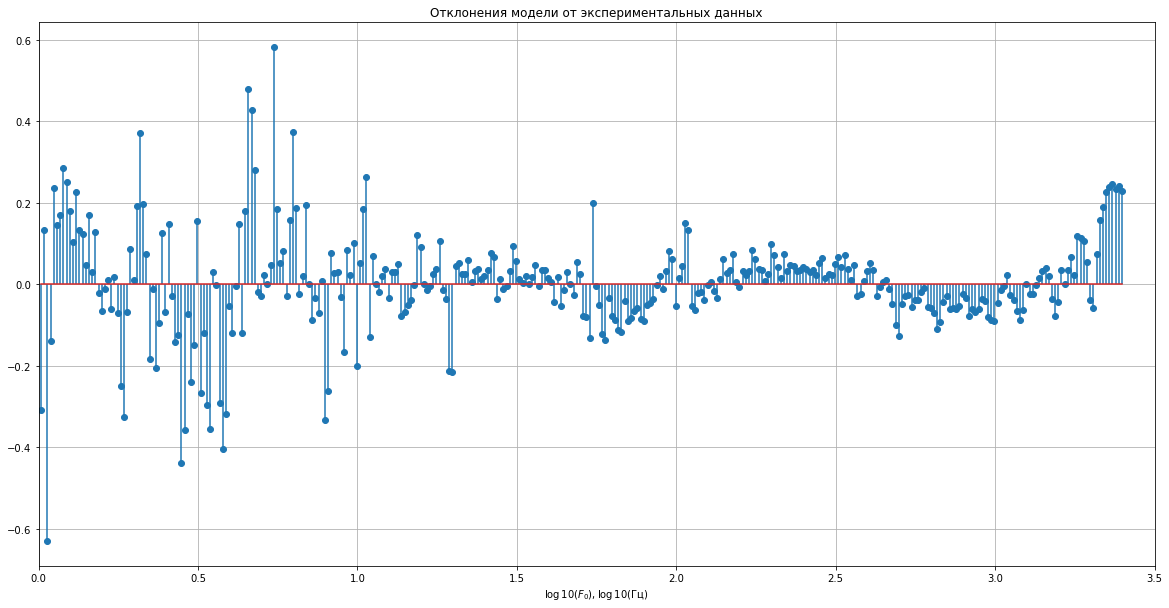

In [86]:
plt.figure(figsize=(20, 10))
plt.stem(X_train, (y_train - y_pred))
plt.grid()
plt.title('Отклонения модели от экспериментальных данных')
plt.xlabel(r'$\log10(F_0), \log10($Гц$)$')
plt.xlim(0, 3.5)
plt.show()

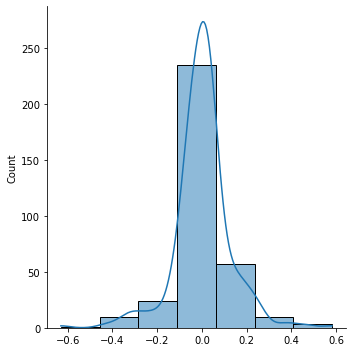

In [84]:
sns.displot(x=y_train - y_pred, bins=7, kde=True)
plt.show()

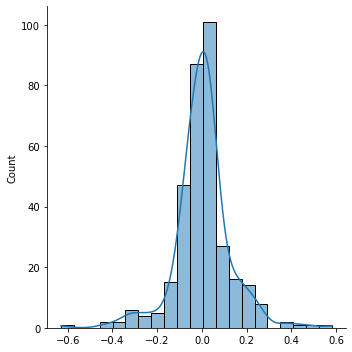

In [93]:
sns.displot(x=y_train - y_pred, bins=21, kde=True)
plt.show()

In [94]:
exps_params_303 = grid_search.best_estimator_.exps_params_
exps_params_303[:, 1] = exps_params_303[:, 1] / k

In [95]:
mean_squared_error(y_train, y_pred, squared=False)

0.12621459894622516